# Cluster Imagez - What's the value of the different modes

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


from tqdm import tqdm

import glob, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

##hack don't know why i suddenly need to do this :/
plt.rcParams['axes.facecolor'] = 'white'

In [2]:
import mflow
from zdata import PdDataStats, ZPdDataset
import utilz, content, preprocess, extract
import report

from sklearn.preprocessing import StandardScaler, PowerTransformer , OneHotEncoder 

In [3]:
report.ZReporter.start("fundusEDA_Clustering")

In [4]:
pdstats = PdDataStats(
                {PdDataStats.DATA_DICT_RECORDZ_KEY: content.STARE_FUNDUS_CONTENT_FPATH,
                PdDataStats.DATA_DICT_HAS_HEADERZ_KEY: True,
                'rec_parser': utilz.FileIO.row_parser                     
                },
                 ftype=PdDataStats.TYPE_TXT_LINES_FILE ) 

pdstats.dframe.describe() 

,fname,fpath,ishape,imin,imax,imean,istd,Normal,Emboli,BRAO,...,ASR,HTR,Coats,MA,CNV,UNDEF,dcodez_id,dcodez_short,dcodez_desc,dnotes
count,397,397,397,397,397,397,397,397,397,397,...,397,397,397,397,397,397,397,397,397,210
unique,397,397,1,2,17,397,397,2,2,2,...,2,2,2,2,2,2,48,48,48,75
top,im0392,/mnt/externz/zRepoz/datasets/fundus/stare/im01...,"(605, 700, 3)",0,255,74.88623927587564,73.484992550325,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14,UNDEF,Unknown Diagnosis,Choroidal Neovascularization AND Age Related M...
freq,1,1,397,371,373,1,1,358,384,390,...,364,361,383,389,336,239,90,90,90,33


In [5]:
def fda_load_fmapz(fmapz_dir, show_it=False):
    if fmapz_dir == _FMAPZ_DIR_RGB:
        tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'eigenz', 'color-eq',  'update-rgb']
        chanz = [ *list(range(5)), 8, (5,6,7)]  
    else:
        tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'yellow', 'eigenz', 'color-eq',  'update-rgb']
        chanz = [ *list(range(6)), 9, (6,7,8)]  
    for fmap_file in sorted( glob.glob(f"{fmapz_dir}/*.fmap.pkl") ):
        with open( fmap_file, "rb") as fd:
            fmap = pickle.load( fd )
        if show_it:
            imgz = [ *[ fmap[:,:,i] for i in chanz ], fmap[:,:,2:5]]
            utilz.Image.plot_images_list( imgz, titlez=tz, nc=len(imgz) , cmap='gray')
        yield fmap

In [6]:
### **** TODO: fix sick+okay/undef 88888
_CLASSES = ['sick', 'okay', 'undef', 'sick-n-undef']
_CLASS_LABELZ = {'sick':0, 'okay':1, 'undef':2, 'sick-n-undef':3}
_N_CLASSES = 22
    
def get_data_infor(X_data):    
    if _N_CLASSES <= 2:
        cname = 'Normal'
    else:
        cname = 'condition'
    data_infor = [ f"{x[0]}__{_CLASSES[int(float(x[1]))]}__{x[2]}" for x in zip(X_data['fname'],X_data[cname], X_data['dcodez_short'])]
    print(data_infor[0])
    return data_infor


if _N_CLASSES > 2:
    pdstats.dframe['condition'] = np.where( ( pdstats.dframe['Normal'] == '1.0') & ( pdstats.dframe['UNDEF'] == '0.0') , 1, 
                                np.where( ( pdstats.dframe['Normal'] == '0.0')&( pdstats.dframe['UNDEF'] == '1.0'), 2, 
                                    np.where(( pdstats.dframe['Normal'] == '1.0')&( pdstats.dframe['UNDEF'] == '1.0'), 3, 0)) ) 
    print( pdstats.dframe['condition'].unique() )
    print( pdstats.dframe['condition'].value_counts())
    _Y_DATA = pdstats.dframe['condition'].values.astype(np.float32) ##TODO: 'dcodez_short'
    _N_CLASSES = len( _CLASSES)
else:
    _Y_DATA = pdstats.dframe['Normal'].values.astype(np.float32) ##TODO: 'dcodez_short'
    _N_CLASSES = 2

print(_Y_DATA[107:107+7])


_DATA_INFOR = get_data_infor(pdstats.dframe) 
# _DATA_INFOR 

[0 2 1 3]
0    202
2    156
1     37
3      2
Name: condition, dtype: int64
[2. 2. 0. 0. 0. 0. 0.]
im0001__sick__BDR-NPDR


In [7]:
_FMAPZ_DIR_RGB = "/mnt/fatsie/xRepoz/output/__00_FMAPZ__RGB/F47" ## No Yellow + RGB only
_FMAPZ_DIR_LAB = "/mnt/fatsie/xRepoz/output/__00_FMAPZ__RGB_LAB_combo/F47" ## with Yellow + LAB&RGB

In [8]:
_USE_LAB = True
if _USE_LAB:
    FMAPZ_DATA = [x for x in tqdm( fda_load_fmapz(_FMAPZ_DIR_RGB) )]
else:
    FMAPZ_DATA = [x for x in tqdm( fda_load_fmapz(_FMAPZ_DIR_LAB) )]

397it [00:04, 87.75it/s] 


In [9]:
fmapz_dir = _FMAPZ_DIR_LAB
def show_some( ls_range):
    if fmapz_dir == _FMAPZ_DIR_RGB:
        tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'eigenz', 'color-eq',  'update-rgb']
        chanz = [ *list(range(5)), 8, (5,6,7)]  
    else:
        tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'yellow', 'eigenz', 'color-eq',  'update-rgb']
        chanz = [ *list(range(6)), 9, (6,7,8)]  
    tmp = [ FMAPZ_DATA[i] for i in ls_range ]    
    for fmap in tmp: 
        imgz = [ *[ fmap[:,:,i] for i in chanz ], fmap[:,:,2:5]]
        utilz.Image.plot_images_list( imgz, titlez=tz, nc=len(imgz) , cmap='gray')

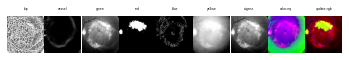

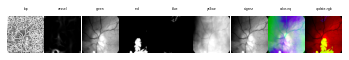

In [10]:
show_some( (1,390))

## Setting up the pipeline

In [38]:
## ======= Channel selectors   =======                  
### ORDER = lbp + vessel + g + r + b + y + origi + eigenz + updated 
if _USE_LAB: ##chanz = [ *list(range(6)), 9, (6,7,8)]  
    _L, _V, _G, _R, _B, _Y, _Ori, _E = 0, 1, 2, 3, 4, 5, (6,7,8), 9
else:
    _L, _V, _G, _R, _B, _Ori, _E = 0, 1, 2, 3, 4, (5,6,7), 8

channelz_origi = [('channelz_origi',extract.ChannelzSelector( ls_channelz=_Ori ) )] 
channelz_g_only = [('channelz_green',extract.ChannelzSelector( ls_channelz=(_G,) ) )] 
channelz_grb = [('channelz_grb',extract.ChannelzSelector( ls_channelz=(_G, _R, _B) ) )] 
channelz_gry = [('channelz_gry',extract.ChannelzSelector( ls_channelz=(_G, _R, _Y) ) )]
channelz_gyb = [('channelz_gyb',extract.ChannelzSelector( ls_channelz=(_G, _Y, _B) ) )]  
channelz_yrb = [('channelz_yrb',extract.ChannelzSelector( ls_channelz=(_Y, _R, _B) ) )] 
channelz_vgrb = [('channelz_vgrb',extract.ChannelzSelector( ls_channelz=(_V, _G, _R, _B) ) )] 
channelz_vgrby = [('channelz_vgrby',extract.ChannelzSelector( ls_channelz=(_V, _G, _R, _B, _Y) ) )] 

channelz_lbp_only = [('channelz_lbp_only',extract.ChannelzSelector( ls_channelz=(_L,) ) )] 
channelz_lbp_grn = [('channelz_lbp_green', extract.ChannelzSelector( ls_channelz=(_L, _G) ) )] 
channelz_lbp_gr = [('channelz_lbp_gr', extract.ChannelzSelector( ls_channelz=(_L, _G, _R) ) )] 
channelz_lbp_gy = [('channelz_lbp_gy', extract.ChannelzSelector( ls_channelz=(_L, _G, _Y) ) )] 
channelz_lbp_ry = [('channelz_lbp_ry', extract.ChannelzSelector( ls_channelz=(_L, _Y, _R,) ) )] 
channelz_lbp_rb = [('channelz_lbp_rb', extract.ChannelzSelector( ls_channelz=(_L, _Y, _R,) ) )] 
channelz_lbp_yb = [('channelz_lbp_yb', extract.ChannelzSelector( ls_channelz=(_L, _Y, _R,) ) )] 
channelz_lbp_gb = [('channelz_lbp_gb', extract.ChannelzSelector( ls_channelz=(_L, _Y, _R,) ) )] 
# channelz_lbp_yb = [('channelz_lbp_grb', extract.ChannelzSelector( ls_channelz=(_L, _Y, _B) ) )] 
# channelz_lbp_gb = [('channelz_lbp_grb', extract.ChannelzSelector( ls_channelz=(_L, _G, _B) ) )] 
channelz_lbp_origi = [('channelz_lbp_origi',extract.ChannelzSelector( ls_channelz=(_L, *_Ori) ) )] 
channelz_lbp_grb = [('channelz_lbp_grb', extract.ChannelzSelector( ls_channelz=(_L, _G, _R, _B) ) )] 
channelz_lbp_grby = [('channelz_lbp_grby', extract.ChannelzSelector( ls_channelz=(_L, _G, _R, _B, _Y) ) )] 
channelz_lbp_vgrb = [('channelz_lbp_vgrb', extract.ChannelzSelector( ls_channelz=(_L, _V, _G, _R, _B) ) )] 

## TODO: on fundus only bila lbp 
channelz_eigz_only = [('channelz_eigz',extract.ChannelzSelector( ls_channelz=(_E,) ) )] 
channelz_eigz_lbp = [('channelz_eigz_lbp',extract.ChannelzSelector( ls_channelz=(_E, _L) ) )] 
channelz_eigz_rb = [('channelz_eigz_rb',extract.ChannelzSelector( ls_channelz=(_E, _R, _B) ) )]
channelz_eigz_ry = [('channelz_eigz_ry',extract.ChannelzSelector( ls_channelz=(_E, _R, _Y) ) )]
channelz_eigz_yb = [('channelz_eigz_yb',extract.ChannelzSelector( ls_channelz=(_E, _Y, _B) ) )]
channelz_eigz_rby = [('channelz_eigz_rby',extract.ChannelzSelector( ls_channelz=(_E, _R, _B, _Y) ) )]
channelz_eigz_lbp_rb = [('channelz_eigz_lbp_rb',extract.ChannelzSelector( ls_channelz=(_E, _L,  _R, _B) ) )]
channelz_eigz_lbp_rby = [('channelz_eigz_lbp_rby',extract.ChannelzSelector( ls_channelz=(_E, _L,  _R, _B, _Y) ) )]



In [12]:
## Reshapez 
flattenor = [ ('flatten', preprocess.Flattenor()), ]
scaler_p = [('scaler', StandardScaler()), ]

# 2. Setup Clustering model

In [13]:
import cv2
import clustering
import pickle 
import torch
import numpy as np 
import os
from glob import glob

from sklearn.pipeline import Pipeline

import seaborn as sns


import utilz

In [39]:
_n_clusters = 4 
_img_resize = (224,224)
_tensor_vgg_img_format = (1,3,224,224)

_outdir = "/mnt/fatsie/xRepoz/output/_00_Kmeans"

_data_pipez = [ #, channelz_g_only, 
               channelz_origi, 
               channelz_grb, channelz_gry, channelz_gyb, 
               #channelz_vgrb, channelz_vgrby,
              
               channelz_lbp_gr, channelz_lbp_gy, channelz_lbp_ry, channelz_lbp_yb,
               #channelz_lbp_only, channelz_lbp_grn, channelz_lbp_origi,
               #channelz_lbp_grb,channelz_lbp_grby, channelz_lbp_vgrb,
              
               #channelz_eigz_only,channelz_eigz_lbp, 
               channelz_eigz_rb, channelz_eigz_ry, channelz_eigz_yb, 
               #channelz_eigz_rby, channelz_eigz_lbp_rb, channelz_eigz_lbp_rby
                ]

get_pipe_name = lambda x: x[0][0] 
fmap_chan_to_tensor_img = lambda x: torch.tensor( utilz.Image.resize_image_dim(x[0], _img_resize).reshape(1, x[1], *_img_resize ).astype('f') )
encoded_to_vectorized_for_kmeans = lambda x: np.dstack(x).reshape(-1, 3)
cluster_centers_to_img = lambda x: x.reshape(*_img_resize,3)

_idn, _fname, _condition, _conditionID, _diseases = list(range(5))
fmap_name_parse = lambda x: (x.split('.'))[0].split('_')

parse_disease = lambda x: "UNDEF" if "UNDEF." in x else\
            "Normal" if "Normal." in x else "Sick"

def fmap_fname_to_data(fdir, fp="*.pkl"):
    O_ = []
    for i, fp in enumerate( sorted(glob(f"{fdir}/*.pkl")) ):
#         print( fp )
        o = [i] + list(fmap_name_parse(os.path.basename(fp) ) ) #[i, *fmap_name_parse(os.path.basename(fp) ) ]
        o[_conditionID] = _CLASS_LABELZ.get(o[_condition], '') 
        o[_condition] = parse_disease( fp )
        O_.append( o )
    return O_ 

def save_pipe_kmeans_to_file(pname, centerz, labelz):
    with open( f"{_outdir}/{pname}.pkl", 'wb') as fd:
        o = {'centers': centerz, 'labels': labelz, 'n_clusters':_n_clusters}
        pickle.dump( o, fd )


def train_encoder_and_fit(X_data, encoder_cnn=None, c=3, n_out=512, epochs=30): ## TODO: VGG @ c = 3 error 
    cnn = clustering.AutoEncoderVGG(pretrained=True, n_channelz=c, out_size=n_out) if encoder_cnn is None else encoder_cnn 
    clustering.train_autoencoder(cnn, X_data , n_epoch=epochs)
    return [list(clustering.predict_autoencoder(cnn, x)) for x in X_data ] 

def cv2_kmeans_cluster(X_data, n_clusters=2):
    stopping_criteria =  (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labelz, (centerz ) = cv2.kmeans(X_data, n_clusters, None, 
                                        stopping_criteria, 10, cv2.KMEANS_RANDOM_CENTERS ) 
    return np.uint8( centerz ), labelz.flatten() 

def pretrain_encoder_with_origi(channz, fmapz, c=3, n_out=512, epochs=100):
    # 1. select channels from fmap 
    X_data = Pipeline( channz ).fit_transform( fmapz ) 
    i_dim = len(X_data[0].shape )
    print("1. In fmap data: ", X_data[0].shape )
    c = X_data[0].shape[2] if i_dim >2 else 1
    # 2. reshape and to tensor
    X_data = [fmap_chan_to_tensor_img( (x, c)) for x in X_data] 
    print("2. Reshaped tensor: ", X_data[0].shape)
    # 3. encode features ; pretrain cnn 
    cnn = clustering.AutoEncoderVGG(pretrained=True, n_channelz=c, out_size=n_out)  
    clustering.train_autoencoder(cnn, X_data , n_epoch=epochs)
    return cnn 

def run_clustering_on_fmap_data(channz, fmapz, encoder=None, n_clusters=_n_clusters, n_out=32,  epochs=10):
    print( "***** RUNNING: ", get_pipe_name(channz) ) 
    # 1. select channels from fmap 
    X_data = Pipeline( channz ).fit_transform( fmapz ) 
    i_dim = len(X_data[0].shape )
    print("1. In fmap data: ", X_data[0].shape )
    c = X_data[0].shape[2] if i_dim >2 else 1
    # 2. reshape and to tensor
    X_data = [fmap_chan_to_tensor_img( (x, c)) for x in X_data] 
    print("2. Reshaped tensor: ", X_data[0].shape)
    # 3. encode features 
    X_encoded = train_encoder_and_fit(X_data, encoder_cnn=encoder, n_out=n_out ,  epochs=epochs )
    print("3. Encoded data: ", X_encoded[0][0].shape )
#     print("3b. encoded ndstack: ", encoded_to_vectorized_for_kmeans(X_encoded[0][0]).shape )
    # 4. reshape for k-means OR not
#     X_encoded = np.vectorize( encoded_to_vectorized_for_kmeans )( X_encoded )
    X_encoded = np.array([ encoded_to_vectorized_for_kmeans(x) for x in X_encoded ])
    print("4. Vectorized data: ", X_encoded[0].shape )
    # 5. kemans run 
    centerz, labelz = cv2_kmeans_cluster(X_encoded, n_clusters)
    print("5. Kmeans clusters: ", len(centerz) , ", ", len(labelz)) 
    # 6. save to file 
    save_pipe_kmeans_to_file(get_pipe_name(channz), centerz, labelz) 
    print("DONE")
    
    return centerz, labelz
    
    
_SUB_FMAPZ = lambda x: FMAPZ_DATA[ : min(x,len(FMAPZ_DATA)) ]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


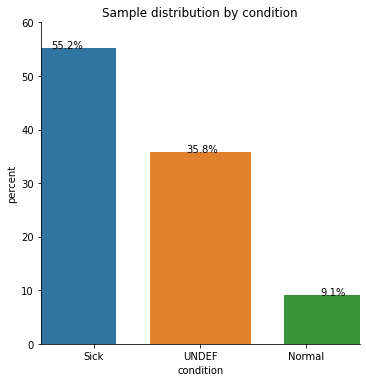

In [15]:
dz = fmap_fname_to_data(_FMAPZ_DIR_LAB) 
parse_disease( 'CNV++UNDEF++ASR++HTR' )
parse_disease( 'UNDEF' )
parse_disease( 'UNDEF.png' )

df = pd.DataFrame.from_records(dz)
df.columns = ['id', 'fname', 'condition', 'cid', 'diseases']
df.head()
t = "Sample distribution by condition"
# df.condition.value_counts().plot(kind='bar')
# sns.countplot(x='condition', data=df).set_title(t)
x_ = 'condition'
# (df[x_]
# .value_counts(normalize=True)
# .mul(100)
# .rename('percent')# .reset_index()
# .pipe((sns.catplot,'data'), x=x_,y='percent',hue=x_,kind='bar'))


df1 = df[x_].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent') #.reset_index()
df1 = pd.DataFrame({'condition': df1.index, "percent":df1.values})
g = sns.catplot(x=x_,y='percent',hue=x_, kind='bar',data=df1)
g.ax.set_ylim(0,60)
g.ax.set_title(t)
new_w = .95
for p in g.ax.patches:
    ##
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

for p in g.ax.patches:   
    # we change the bar width
    cur_w = p.get_width()
    diff = cur_w - new_w
    p.set_width(new_w)
    # we recenter the bar
    p.set_x(p.get_x() + diff * .5)
    
    
plt.show(); 

In [16]:
__FMAPZ_n = _SUB_FMAPZ(700)
_N_CLUSTERZ = 5
_N_OUT = 64 

In [50]:
if _USE_LAB:
    _VIZ_DATA = fmap_fname_to_data(_FMAPZ_DIR_RGB)  
else:
    _VIZ_DATA = fmap_fname_to_data(_FMAPZ_DIR_LAB) 
    
_VIZ_DATA = _VIZ_DATA[:len(__FMAPZ_n)]
    
def plot_centers(name, centerz, n=_n_clusters):
#     print( type(centerz[0]), centerz[0].shape )
    imgz = [cluster_centers_to_img(x) for x in centerz]
    tz = [f"cluster_{c}" for c in range( n )]
    print(f"Data Channel {name} with img-sze {imgz[0].shape }")
    utilz.Image.plot_images_list(imgz, titlez=tz, nc=len(imgz), save=f"centerz__{name}", tdir=_outdir, tfont=7)
    
def plot_clusters(name, labelz, n=_n_clusters):
    conditionz = [ int(v[_conditionID]) for v in _VIZ_DATA ]
    conditionz = [ v[_condition] for v in _VIZ_DATA ]
    idz = [ int(v[int(_idn)]) for v in _VIZ_DATA ]
    labelz = [ f"cluster-{l+1}" for l in  labelz ] #int(l)
    df = pd.DataFrame(list(zip(idz, conditionz, labelz)), columns=['idz', 'condz', 'labelz'])
#     g = sns.FacetGrid( df, col='labelz', height=4, aspect=1, hue='condz')
#     g.map( sns.swarmplot, 'condz', 'idz')
#     g = sns.swarmplot( df, 'labelz','condz', height=4, aspect=1)
    g = sns.factorplot(x="labelz", y="condz", hue="labelz", col="condz", data=df, kind="swarm")
    g.set_title( name )
    g.add_legend();
        
    
        

In [27]:
## A. Pretrain with origi
encoder_cnn = pretrain_encoder_with_origi(channelz_origi, __FMAPZ_n, epochs=100, n_out=_N_OUT)
with open(f"{_outdir}/pretrained_encoder.pkl", 'wb') as fd:
    pickle.dump(encoder_cnn, fd )

1. In fmap data:  (168, 168, 3)
2. Reshaped tensor:  torch.Size([1, 3, 224, 224])


  0%|          | 0/100 [00:00<?, ?it/s]

Setup AE


  1%|          | 1/100 [06:09<10:09:46, 369.56s/it]

E 0: loss 117.12880327552557


  2%|▏         | 2/100 [12:16<10:01:30, 368.27s/it]

E 1: loss 24.908184584230185


  3%|▎         | 3/100 [18:22<9:53:26, 367.07s/it] 

E 2: loss 21.776805175468326


  4%|▍         | 4/100 [24:28<9:46:40, 366.68s/it]

E 3: loss 20.36855141632259


  5%|▌         | 5/100 [30:35<9:40:57, 366.92s/it]

E 4: loss 19.45560578070581


  6%|▌         | 6/100 [36:42<9:34:38, 366.79s/it]

E 5: loss 18.82806377671659


  7%|▋         | 7/100 [42:49<9:28:27, 366.74s/it]

E 6: loss 18.318309668451548


  8%|▊         | 8/100 [48:56<9:22:41, 366.98s/it]

E 7: loss 17.898666217923164


  9%|▉         | 9/100 [55:04<9:16:49, 367.14s/it]

E 8: loss 17.55274636670947


 10%|█         | 10/100 [1:01:11<9:10:53, 367.26s/it]

E 9: loss 17.23762596398592


 11%|█         | 11/100 [1:07:19<9:05:14, 367.58s/it]

E 10: loss 16.98213110677898


 12%|█▏        | 12/100 [1:13:29<8:59:49, 368.06s/it]

E 11: loss 16.71511154063046


 13%|█▎        | 13/100 [1:19:39<8:54:51, 368.86s/it]

E 12: loss 16.50809850730002


 14%|█▍        | 14/100 [1:25:50<8:49:36, 369.49s/it]

E 13: loss 16.29553297534585


 15%|█▌        | 15/100 [1:32:02<8:44:31, 370.25s/it]

E 14: loss 16.118319619446993


 16%|█▌        | 16/100 [1:38:14<8:38:51, 370.61s/it]

E 15: loss 15.952635541558266


 17%|█▋        | 17/100 [1:44:27<8:33:54, 371.49s/it]

E 16: loss 15.823044892400503


 18%|█▊        | 18/100 [1:50:36<8:26:21, 370.50s/it]

E 17: loss 15.693989418447018


 19%|█▉        | 19/100 [1:56:44<8:19:10, 369.75s/it]

E 18: loss 15.57902341708541


 20%|██        | 20/100 [2:02:53<8:12:45, 369.57s/it]

E 19: loss 15.480333119630814


 21%|██        | 21/100 [2:09:01<8:06:03, 369.16s/it]

E 20: loss 15.385678002610803


 22%|██▏       | 22/100 [2:15:09<7:59:23, 368.77s/it]

E 21: loss 15.324728639796376


 23%|██▎       | 23/100 [2:21:17<7:52:59, 368.56s/it]

E 22: loss 15.230728808790445


 24%|██▍       | 24/100 [2:27:28<7:47:48, 369.32s/it]

E 23: loss 15.172345887869596


 25%|██▌       | 25/100 [2:33:37<7:41:30, 369.21s/it]

E 24: loss 15.10893065854907


 26%|██▌       | 26/100 [2:39:44<7:34:36, 368.60s/it]

E 25: loss 15.04440782032907


 27%|██▋       | 27/100 [2:45:50<7:27:38, 367.92s/it]

E 26: loss 14.99910268560052


 28%|██▊       | 28/100 [2:51:56<7:20:47, 367.33s/it]

E 27: loss 14.92733233422041


 29%|██▉       | 29/100 [2:58:08<7:16:06, 368.54s/it]

E 28: loss 14.879698457196355


 30%|███       | 30/100 [3:04:39<7:17:59, 375.42s/it]

E 29: loss 14.82375843450427


 31%|███       | 31/100 [3:10:48<7:09:24, 373.40s/it]

E 30: loss 14.778676537796855


 32%|███▏      | 32/100 [3:16:55<7:01:12, 371.66s/it]

E 31: loss 14.753821382299066


 33%|███▎      | 33/100 [3:23:05<6:54:21, 371.06s/it]

E 32: loss 14.702070634812117


 34%|███▍      | 34/100 [3:29:15<6:47:49, 370.76s/it]

E 33: loss 14.646137192845345


 35%|███▌      | 35/100 [3:35:25<6:41:28, 370.60s/it]

E 34: loss 14.605674291029572


 36%|███▌      | 36/100 [3:41:37<6:35:30, 370.79s/it]

E 35: loss 14.576204769313335


 37%|███▋      | 37/100 [3:47:46<6:28:53, 370.37s/it]

E 36: loss 14.518462873995304


 38%|███▊      | 38/100 [3:53:58<6:23:06, 370.75s/it]

E 37: loss 14.496121790260077


 39%|███▉      | 39/100 [4:00:07<6:16:32, 370.37s/it]

E 38: loss 14.46462139673531


 40%|████      | 40/100 [4:06:17<6:10:18, 370.31s/it]

E 39: loss 14.404428765177727


 41%|████      | 41/100 [4:12:27<6:04:03, 370.22s/it]

E 40: loss 14.36365376226604


 42%|████▏     | 42/100 [4:18:37<5:57:41, 370.02s/it]

E 41: loss 14.330643706023693


 43%|████▎     | 43/100 [4:24:47<5:51:28, 369.97s/it]

E 42: loss 14.307005193084478


 44%|████▍     | 44/100 [4:30:57<5:45:29, 370.16s/it]

E 43: loss 14.240286514163017


 45%|████▌     | 45/100 [4:37:06<5:38:54, 369.73s/it]

E 44: loss 14.185400675982237


 46%|████▌     | 46/100 [4:43:14<5:32:10, 369.08s/it]

E 45: loss 14.141831824555993


 47%|████▋     | 47/100 [4:49:21<5:25:37, 368.63s/it]

E 46: loss 14.09625500626862


 48%|████▊     | 48/100 [4:55:28<5:19:07, 368.21s/it]

E 47: loss 14.086270393803716


 49%|████▉     | 49/100 [5:01:35<5:12:36, 367.77s/it]

E 48: loss 14.017886873334646


 50%|█████     | 50/100 [5:07:43<5:06:23, 367.67s/it]

E 49: loss 13.9964967276901


 51%|█████     | 51/100 [5:13:50<5:00:08, 367.51s/it]

E 50: loss 13.935876905918121


 52%|█████▏    | 52/100 [5:19:58<4:54:08, 367.68s/it]

E 51: loss 13.878670189529657


 53%|█████▎    | 53/100 [5:26:06<4:48:08, 367.84s/it]

E 52: loss 13.829873502254486


 54%|█████▍    | 54/100 [5:32:15<4:42:11, 368.07s/it]

E 53: loss 13.78213545307517


 55%|█████▌    | 55/100 [5:38:23<4:36:09, 368.22s/it]

E 54: loss 13.738200444728136


 56%|█████▌    | 56/100 [5:44:31<4:29:55, 368.09s/it]

E 55: loss 13.693613205105066


 57%|█████▋    | 57/100 [5:50:38<4:23:37, 367.86s/it]

E 56: loss 13.646381327882409


 58%|█████▊    | 58/100 [5:56:46<4:17:24, 367.72s/it]

E 57: loss 13.614976782351732


 59%|█████▉    | 59/100 [6:02:53<4:11:07, 367.50s/it]

E 58: loss 13.571663681417704


 60%|██████    | 60/100 [6:09:00<4:04:57, 367.45s/it]

E 59: loss 13.528404893353581


 61%|██████    | 61/100 [6:15:06<3:58:39, 367.16s/it]

E 60: loss 13.485789647325873


 62%|██████▏   | 62/100 [6:21:14<3:52:31, 367.14s/it]

E 61: loss 13.443303344771266


 63%|██████▎   | 63/100 [6:27:20<3:46:18, 366.97s/it]

E 62: loss 13.407517476007342


 64%|██████▍   | 64/100 [6:33:28<3:40:24, 367.34s/it]

E 63: loss 13.368150586262345


 65%|██████▌   | 65/100 [6:39:35<3:34:14, 367.26s/it]

E 64: loss 13.335114106535912


 66%|██████▌   | 66/100 [6:45:43<3:28:10, 367.36s/it]

E 65: loss 13.298545025289059


 67%|██████▋   | 67/100 [6:51:51<3:22:13, 367.67s/it]

E 66: loss 13.263745706528425


 68%|██████▊   | 68/100 [6:58:00<3:16:17, 368.04s/it]

E 67: loss 13.226969605311751


 69%|██████▉   | 69/100 [7:04:10<3:10:22, 368.47s/it]

E 68: loss 13.192713353782892


 70%|███████   | 70/100 [7:10:19<3:04:23, 368.80s/it]

E 69: loss 13.155157035216689


 71%|███████   | 71/100 [7:16:28<2:58:13, 368.73s/it]

E 70: loss 13.12872264161706


 72%|███████▏  | 72/100 [7:22:37<2:52:03, 368.71s/it]

E 71: loss 13.104371445253491


 73%|███████▎  | 73/100 [7:28:44<2:45:48, 368.46s/it]

E 72: loss 13.138243677094579


 74%|███████▍  | 74/100 [7:34:52<2:39:36, 368.31s/it]

E 73: loss 13.059441613033414


 75%|███████▌  | 75/100 [7:41:00<2:33:24, 368.17s/it]

E 74: loss 13.021220069378614


 76%|███████▌  | 76/100 [7:47:09<2:27:17, 368.22s/it]

E 75: loss 12.980230923742056


 77%|███████▋  | 77/100 [7:53:17<2:21:09, 368.25s/it]

E 76: loss 12.943503979593515


 78%|███████▊  | 78/100 [7:59:26<2:15:06, 368.47s/it]

E 77: loss 12.908778516575694


 79%|███████▉  | 79/100 [8:05:35<2:09:01, 368.65s/it]

E 78: loss 12.882285971194506


 80%|████████  | 80/100 [8:11:44<2:02:54, 368.74s/it]

E 79: loss 12.843995543196797


 81%|████████  | 81/100 [8:17:52<1:56:41, 368.49s/it]

E 80: loss 12.805419851094484


 82%|████████▏ | 82/100 [8:24:00<1:50:32, 368.49s/it]

E 81: loss 12.767846370115876


 83%|████████▎ | 83/100 [8:30:09<1:44:25, 368.58s/it]

E 82: loss 12.738477537408471


 84%|████████▍ | 84/100 [8:36:18<1:38:17, 368.59s/it]

E 83: loss 12.705791810527444


 85%|████████▌ | 85/100 [8:42:26<1:32:07, 368.53s/it]

E 84: loss 12.67321308888495


 86%|████████▌ | 86/100 [8:48:35<1:26:02, 368.75s/it]

E 85: loss 12.639574840664864


 87%|████████▋ | 87/100 [8:54:43<1:19:50, 368.53s/it]

E 86: loss 12.611085161566734


 88%|████████▊ | 88/100 [9:00:51<1:13:39, 368.30s/it]

E 87: loss 12.578897209838033


 89%|████████▉ | 89/100 [9:06:59<1:07:31, 368.27s/it]

E 88: loss 12.555679712444544


 90%|█████████ | 90/100 [9:13:07<1:01:22, 368.23s/it]

E 89: loss 12.524556940421462


 91%|█████████ | 91/100 [9:19:16<55:16, 368.45s/it]  

E 90: loss 12.502804121002555


 92%|█████████▏| 92/100 [9:25:24<49:05, 368.25s/it]

E 91: loss 12.466940687969327


 93%|█████████▎| 93/100 [9:31:33<42:58, 368.36s/it]

E 92: loss 12.43926578387618


 94%|█████████▍| 94/100 [9:37:41<36:49, 368.21s/it]

E 93: loss 12.401904318481684


 95%|█████████▌| 95/100 [9:43:49<30:41, 368.21s/it]

E 94: loss 12.373144844546914


 96%|█████████▌| 96/100 [9:49:59<24:34, 368.66s/it]

E 95: loss 12.332643093541265


 97%|█████████▋| 97/100 [9:56:08<18:26, 368.76s/it]

E 96: loss 12.299788482487202


 98%|█████████▊| 98/100 [10:02:17<12:17, 368.84s/it]

E 97: loss 12.266218701377511


 99%|█████████▉| 99/100 [10:08:24<06:08, 368.41s/it]

E 98: loss 12.24013838171959


100%|██████████| 100/100 [10:14:32<00:00, 368.73s/it]

E 99: loss 12.206573780626059


In [52]:
## For each pipeline 'sub-train'
##   1. fetch channel + encode + k-means 
##   3. save centers and labels 
cluster_results = {} 
for channel in tqdm(_data_pipez ):
    fname = get_pipe_name(channel) 
    centerz, labelz = run_clustering_on_fmap_data(channel, __FMAPZ_n, epochs=10, 
                                                  encoder=encoder_cnn, 
                                                  n_clusters=_N_CLUSTERZ, 
                                                  n_out=_N_OUT)
    cluster_results[fname] = (centerz, labelz)

print( [k for k in cluster_results.keys() ])

  0%|          | 0/11 [00:00<?, ?it/s]

***** RUNNING:  channelz_origi
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [06:06<54:57, 366.35s/it]

E 0: loss 22.61718994937837



 20%|██        | 2/10 [12:08<48:32, 364.07s/it]

E 1: loss 20.486702421680093



 30%|███       | 3/10 [18:11<42:22, 363.21s/it]

E 2: loss 19.812930470332503



 40%|████      | 4/10 [24:23<36:42, 367.06s/it]

E 3: loss 19.343610905110836



 50%|█████     | 5/10 [30:24<30:23, 364.78s/it]

E 4: loss 18.939447075128555



 60%|██████    | 6/10 [36:25<24:13, 363.45s/it]

E 5: loss 18.599997522309422



 70%|███████   | 7/10 [42:26<18:07, 362.56s/it]

E 6: loss 18.303486278280616



 80%|████████  | 8/10 [48:27<12:03, 361.99s/it]

E 7: loss 18.046041449531913



 90%|█████████ | 9/10 [54:31<06:02, 362.64s/it]

E 8: loss 17.8130167927593



100%|██████████| 10/10 [1:00:31<00:00, 363.17s/it]

E 9: loss 17.60528738051653


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


  9%|▉         | 1/11 [1:02:35<10:25:55, 3755.54s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_grb
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [06:05<54:47, 365.24s/it]

E 0: loss 16.191589606925845



 20%|██        | 2/10 [12:11<48:44, 365.59s/it]

E 1: loss 13.023902992717922



 30%|███       | 3/10 [18:17<42:40, 365.75s/it]

E 2: loss 12.525708643719554



 40%|████      | 4/10 [24:22<36:34, 365.69s/it]

E 3: loss 12.166919159702957



 50%|█████     | 5/10 [30:29<30:30, 366.12s/it]

E 4: loss 11.888754790648818



 60%|██████    | 6/10 [36:34<24:23, 365.79s/it]

E 5: loss 11.657016323879361



 70%|███████   | 7/10 [42:41<18:18, 366.04s/it]

E 6: loss 11.455982591025531



 80%|████████  | 8/10 [48:46<12:11, 365.81s/it]

E 7: loss 11.278072147630155



 90%|█████████ | 9/10 [54:51<06:05, 365.43s/it]

E 8: loss 11.117206531576812



100%|██████████| 10/10 [1:00:56<00:00, 365.62s/it]

E 9: loss 10.97029280103743


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 18%|█▊        | 2/11 [2:05:35<9:25:29, 3769.93s/it] 

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_gry
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [06:03<54:35, 363.95s/it]

E 0: loss 17.78299644589424



 20%|██        | 2/10 [12:07<48:31, 364.00s/it]

E 1: loss 16.41961359605193



 30%|███       | 3/10 [18:12<42:29, 364.17s/it]

E 2: loss 16.00714741460979



 40%|████      | 4/10 [24:16<36:24, 364.14s/it]

E 3: loss 15.695816876366735



 50%|█████     | 5/10 [30:21<30:21, 364.34s/it]

E 4: loss 15.438194470480084



 60%|██████    | 6/10 [36:25<24:17, 364.47s/it]

E 5: loss 15.215077662840486



 70%|███████   | 7/10 [42:30<18:13, 364.51s/it]

E 6: loss 15.01958110742271



 80%|████████  | 8/10 [48:34<12:08, 364.47s/it]

E 7: loss 14.84111350774765



 90%|█████████ | 9/10 [54:38<06:04, 364.23s/it]

E 8: loss 14.680059030652046



100%|██████████| 10/10 [1:00:42<00:00, 364.27s/it]

E 9: loss 14.528695559129119


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 27%|██▋       | 3/11 [3:08:21<8:22:25, 3768.18s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_gyb
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [05:59<53:53, 359.24s/it]

E 0: loss 12.126256042160094



 20%|██        | 2/10 [11:58<47:52, 359.05s/it]

E 1: loss 10.917130643501878



 30%|███       | 3/10 [17:57<41:53, 359.09s/it]

E 2: loss 10.51297621242702



 40%|████      | 4/10 [23:56<35:55, 359.29s/it]

E 3: loss 10.250111741945148



 50%|█████     | 5/10 [29:56<29:57, 359.57s/it]

E 4: loss 10.04924201965332



 60%|██████    | 6/10 [35:57<24:00, 360.01s/it]

E 5: loss 9.88240177091211



 70%|███████   | 7/10 [42:09<18:11, 363.79s/it]

E 6: loss 9.72922054771334



 80%|████████  | 8/10 [48:11<12:06, 363.21s/it]

E 7: loss 9.606397932395339



 90%|█████████ | 9/10 [54:12<06:02, 362.54s/it]

E 8: loss 9.501209857873619



100%|██████████| 10/10 [1:00:13<00:00, 361.39s/it]

E 9: loss 9.40743657015264


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 36%|███▋      | 4/11 [4:10:47<7:18:34, 3759.18s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_lbp_gr
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [06:17<56:39, 377.73s/it]

E 0: loss 3722.8086434602737



 20%|██        | 2/10 [12:20<49:12, 369.04s/it]

E 1: loss 916.2215354442596



 30%|███       | 3/10 [18:22<42:39, 365.59s/it]

E 2: loss 854.6404695510864



 40%|████      | 4/10 [24:23<36:22, 363.75s/it]

E 3: loss 818.3185639381409



 50%|█████     | 5/10 [30:23<30:12, 362.58s/it]

E 4: loss 789.6405063867569



 60%|██████    | 6/10 [36:24<24:07, 361.96s/it]

E 5: loss 766.5694316625595



 70%|███████   | 7/10 [42:24<18:04, 361.49s/it]

E 6: loss 747.2918231487274



 80%|████████  | 8/10 [48:25<12:02, 361.31s/it]

E 7: loss 728.9288538694382



 90%|█████████ | 9/10 [54:26<06:00, 360.97s/it]

E 8: loss 713.8766620159149



100%|██████████| 10/10 [1:00:26<00:00, 362.66s/it]

E 9: loss 700.8380864858627


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 45%|████▌     | 5/11 [5:13:20<6:15:42, 3757.12s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_lbp_gy
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [05:47<52:03, 347.03s/it]

E 0: loss 681.1456030607224



 20%|██        | 2/10 [11:34<46:18, 347.36s/it]

E 1: loss 677.2688442468643



 30%|███       | 3/10 [17:22<40:32, 347.52s/it]

E 2: loss 662.7212105989456



 40%|████      | 4/10 [23:09<34:44, 347.41s/it]

E 3: loss 653.6931359767914



 50%|█████     | 5/10 [29:00<29:03, 348.75s/it]

E 4: loss 646.5387423038483



 60%|██████    | 6/10 [34:51<23:17, 349.47s/it]

E 5: loss 638.8255929946899



 70%|███████   | 7/10 [40:42<17:30, 350.04s/it]

E 6: loss 630.5094829797745



 80%|████████  | 8/10 [46:33<11:40, 350.19s/it]

E 7: loss 623.9468599557877



 90%|█████████ | 9/10 [52:23<05:50, 350.33s/it]

E 8: loss 614.917971611023



100%|██████████| 10/10 [58:14<00:00, 349.49s/it]

E 9: loss 605.0213490724564


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 55%|█████▍    | 6/11 [6:13:43<5:09:17, 3711.53s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_lbp_ry
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [06:02<54:24, 362.67s/it]

E 0: loss 603.777287364006



 20%|██        | 2/10 [12:05<48:22, 362.82s/it]

E 1: loss 593.0343540906906



 30%|███       | 3/10 [18:11<42:28, 364.10s/it]

E 2: loss 580.5268722772598



 40%|████      | 4/10 [24:12<36:18, 363.07s/it]

E 3: loss 593.5995908975601



 50%|█████     | 5/10 [30:15<30:14, 362.88s/it]

E 4: loss 643.7190163135529



 60%|██████    | 6/10 [36:17<24:10, 362.63s/it]

E 5: loss 627.3079447746277



 70%|███████   | 7/10 [42:18<18:06, 362.22s/it]

E 6: loss 613.9607541561127



 80%|████████  | 8/10 [48:20<12:04, 362.11s/it]

E 7: loss 617.3692357540131



 90%|█████████ | 9/10 [54:22<06:02, 362.16s/it]

E 8: loss 610.4601781368256



100%|██████████| 10/10 [1:00:24<00:00, 362.47s/it]

E 9: loss 593.0664708614349


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 64%|██████▎   | 7/11 [7:16:13<4:08:16, 3724.23s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_lbp_yb
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [06:08<55:15, 368.39s/it]

E 0: loss 577.9946075677872



 20%|██        | 2/10 [12:16<49:07, 368.45s/it]

E 1: loss 572.1074382066727



 30%|███       | 3/10 [18:24<42:57, 368.18s/it]

E 2: loss 553.9904894828796



 40%|████      | 4/10 [24:32<36:48, 368.01s/it]

E 3: loss 558.9452841281891



 50%|█████     | 5/10 [30:37<30:34, 366.92s/it]

E 4: loss 555.2553639411926



 60%|██████    | 6/10 [36:43<24:25, 366.45s/it]

E 5: loss 591.5837090015411



 70%|███████   | 7/10 [42:48<18:18, 366.13s/it]

E 6: loss 589.1467846632004



 80%|████████  | 8/10 [48:53<12:11, 365.89s/it]

E 7: loss 568.4033294916153



 90%|█████████ | 9/10 [54:58<06:05, 365.60s/it]

E 8: loss 550.6867606639862



100%|██████████| 10/10 [1:01:04<00:00, 366.48s/it]

E 9: loss 534.4463696479797


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 73%|███████▎  | 8/11 [8:19:23<3:07:15, 3745.01s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_eigz_rb
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [05:49<52:26, 349.65s/it]

E 0: loss 412.055775411427



 20%|██        | 2/10 [11:39<46:40, 350.04s/it]

E 1: loss 29.50901659205556



 30%|███       | 3/10 [17:28<40:46, 349.43s/it]

E 2: loss 21.986284213140607



 40%|████      | 4/10 [23:18<34:57, 349.67s/it]

E 3: loss 18.570926640182734



 50%|█████     | 5/10 [29:07<29:06, 349.30s/it]

E 4: loss 16.62763107661158



 60%|██████    | 6/10 [34:57<23:17, 349.47s/it]

E 5: loss 15.364815617911518



 70%|███████   | 7/10 [40:46<17:27, 349.33s/it]

E 6: loss 14.472162777557969



 80%|████████  | 8/10 [46:34<11:37, 348.88s/it]

E 7: loss 13.794397504068911



 90%|█████████ | 9/10 [52:24<05:49, 349.26s/it]

E 8: loss 13.258568349294364



100%|██████████| 10/10 [58:16<00:00, 349.68s/it]

E 9: loss 12.813976588658988


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 82%|████████▏ | 9/11 [9:19:44<2:03:32, 3706.30s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_eigz_ry
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [05:54<53:07, 354.16s/it]

E 0: loss 24.284902218729258



 20%|██        | 2/10 [11:50<47:22, 355.35s/it]

E 1: loss 21.685974158346653



 30%|███       | 3/10 [17:45<41:26, 355.20s/it]

E 2: loss 20.354920502752066



 40%|████      | 4/10 [23:40<35:29, 354.99s/it]

E 3: loss 19.354414708912373



 50%|█████     | 5/10 [29:38<29:40, 356.17s/it]

E 4: loss 18.55700510367751



 60%|██████    | 6/10 [35:34<23:44, 356.17s/it]

E 5: loss 17.893247958272696



 70%|███████   | 7/10 [41:29<17:47, 355.96s/it]

E 6: loss 17.32511756569147



 80%|████████  | 8/10 [47:25<11:51, 355.70s/it]

E 7: loss 16.83714860677719



 90%|█████████ | 9/10 [53:19<05:55, 355.36s/it]

E 8: loss 16.403739131987095



100%|██████████| 10/10 [59:16<00:00, 355.61s/it]

E 9: loss 16.018433071672916


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


 91%|█████████ | 10/11 [10:21:06<1:01:38, 3698.75s/it]

5. Kmeans clusters:  5 ,  397
DONE
***** RUNNING:  channelz_eigz_yb
1. In fmap data:  (168, 168, 3)



  0%|          | 0/10 [00:00<?, ?it/s]

2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



 10%|█         | 1/10 [05:51<52:45, 351.76s/it]

E 0: loss 13.245018064975739



 20%|██        | 2/10 [11:44<46:58, 352.32s/it]

E 1: loss 11.204424138180912



 30%|███       | 3/10 [17:38<41:12, 353.28s/it]

E 2: loss 10.629750542342663



 40%|████      | 4/10 [23:35<35:28, 354.70s/it]

E 3: loss 10.309315201826394



 50%|█████     | 5/10 [29:30<29:33, 354.64s/it]

E 4: loss 10.079528274014592



 60%|██████    | 6/10 [35:21<23:33, 353.36s/it]

E 5: loss 9.897228707559407



 70%|███████   | 7/10 [41:12<17:38, 352.77s/it]

E 6: loss 9.74214650504291



 80%|████████  | 8/10 [47:03<11:44, 352.10s/it]

E 7: loss 9.606298506259918



 90%|█████████ | 9/10 [52:54<05:51, 351.91s/it]

E 8: loss 9.484221573919058



100%|██████████| 10/10 [58:46<00:00, 352.64s/it]

E 9: loss 9.373693005181849


3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)


100%|██████████| 11/11 [11:21:57<00:00, 3719.78s/it]  

5. Kmeans clusters:  5 ,  397
DONE
['channelz_origi', 'channelz_grb', 'channelz_gry', 'channelz_gyb', 'channelz_lbp_gr', 'channelz_lbp_gy', 'channelz_lbp_ry', 'channelz_lbp_yb', 'channelz_eigz_rb', 'channelz_eigz_ry', 'channelz_eigz_yb']


**** PLOTING CENTERS 
Data Channel channelz_origi with img-sze (224, 224, 3)


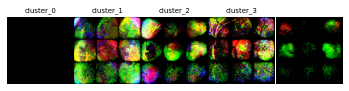

<Figure size 432x288 with 0 Axes>

Data Channel channelz_grb with img-sze (224, 224, 3)


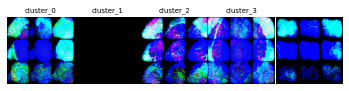

<Figure size 432x288 with 0 Axes>

Data Channel channelz_gry with img-sze (224, 224, 3)


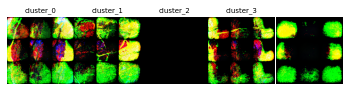

<Figure size 432x288 with 0 Axes>

Data Channel channelz_gyb with img-sze (224, 224, 3)


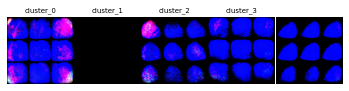

<Figure size 432x288 with 0 Axes>

Data Channel channelz_lbp_gr with img-sze (224, 224, 3)


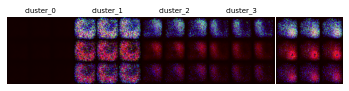

<Figure size 432x288 with 0 Axes>

Data Channel channelz_lbp_gy with img-sze (224, 224, 3)


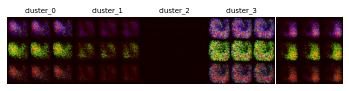

<Figure size 432x288 with 0 Axes>

Data Channel channelz_lbp_ry with img-sze (224, 224, 3)


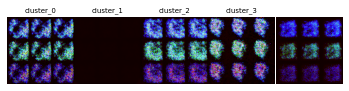

<Figure size 432x288 with 0 Axes>

Data Channel channelz_lbp_yb with img-sze (224, 224, 3)


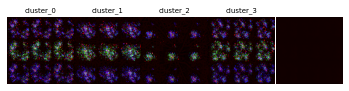

<Figure size 432x288 with 0 Axes>

Data Channel channelz_eigz_rb with img-sze (224, 224, 3)


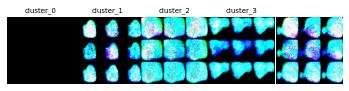

<Figure size 432x288 with 0 Axes>

Data Channel channelz_eigz_ry with img-sze (224, 224, 3)


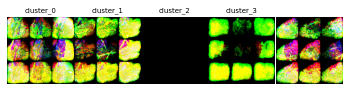

<Figure size 432x288 with 0 Axes>

Data Channel channelz_eigz_yb with img-sze (224, 224, 3)


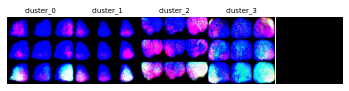

<Figure size 432x288 with 0 Axes>

In [53]:
print("**** PLOTING CENTERS " )
for fname, cls in cluster_results.items():
    centerz, labelz = cls 
    plot_centers(fname, centerz)
    plt.clf()
    plt.show();

**** PLOTING Facet 
4367


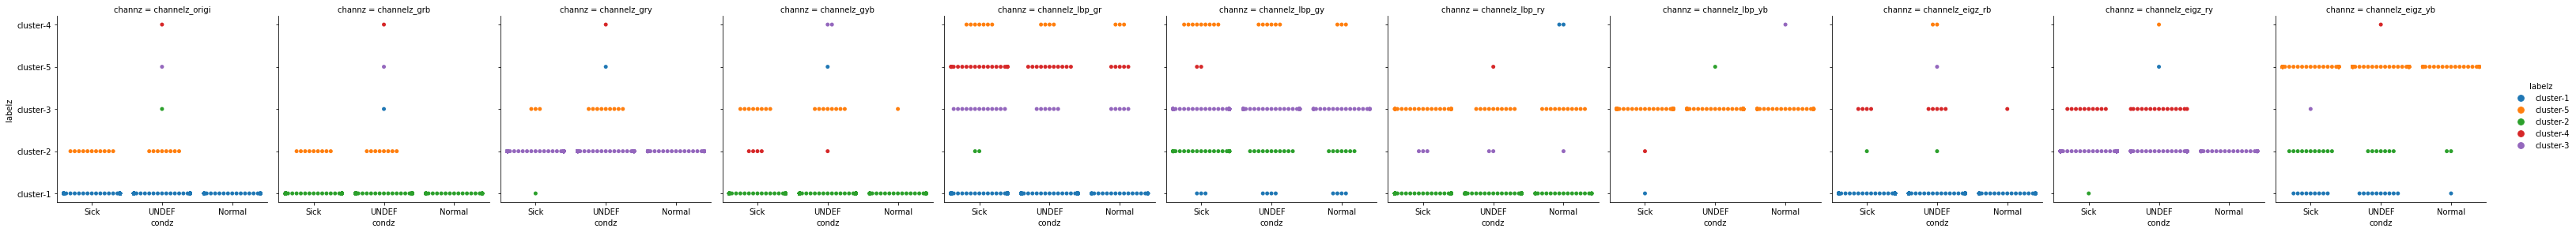

In [54]:
print("**** PLOTING Facet " )
# conditionz = [ int(v[_conditionID]) for v in _VIZ_DATA ]
conditionz = [ v[_condition] for v in _VIZ_DATA ]
idz = [ int(v[int(_idn)]) for v in _VIZ_DATA ]

_IDZ, _CONDZ, _LBLZ, _CHANZ = [], [], [], []
for fname, cls in cluster_results.items():
    centerz, labelz = cls 
    channz = [f"{fname}"]*len(_VIZ_DATA)     
    labelz = [ f"cluster-{l+1}" for l in  labelz ] #int(l)
    _IDZ += idz
    _CONDZ += conditionz 
    _LBLZ += labelz 
    _CHANZ += channz 
    
df = pd.DataFrame(list(zip(_IDZ, _CONDZ, _LBLZ, _CHANZ)), columns=['idz', 'condz', 'labelz', 'channz'])
print( len(df) ) 

g = sns.factorplot(y="labelz", x="condz", hue="labelz", col="channz", 
                   data=df, kind="swarm", height=4, aspect=1) 
# g.set_title( 'K-Means Clusters' )
# g.add_legend();

plt.savefig( f"{_outdir}/Cluster Maps.png", dpi=300, facecolor='white')
    

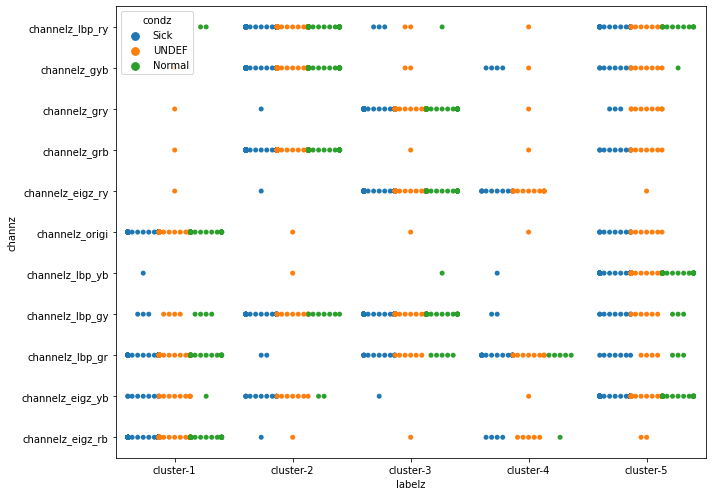

In [55]:
y_ = [ int(y)%10 for y in df.idz ]
fig, ax = plt.subplots(figsize=(10, 7) )
g = sns.swarmplot(x='labelz', y="channz", hue="condz", data=df.sort_values(['channz','labelz']), dodge=True, ax=ax) 
# g.set_title( 'K-Means Clusters' )
# g.add_legend();
plt.tight_layout()
plt.savefig( f"{_outdir}/Cluster Maps V2.png", dpi=300, facecolor='white')
    

In [56]:
# cname = "channelz_origi"
# x_ = 'cluster_labelz'

# ### Sample distribution by clusters
# nr, nc, pi = 4, 3, 1
# for cname in cluster_results.keys():
#     centerz, labelz = cluster_results.get(cname, "")
#     df = pd.DataFrame.from_records(dz)
#     df.columns = ['id', 'fname', 'condition', 'cid', 'diseases']
#     df[x_] = labelz
#     df.head()

#     t = f"Sample distribution by cluster classes - {cname}"
    
#     df1 = df[x_].value_counts(normalize=True)
#     df1 = df1.mul(100)
#     df1 = df1.rename('percent') #.reset_index()
#     df1 = pd.DataFrame({'cluster_labelz': df1.index, "percent":df1.values})
    
# #     plt.subplot(nr, nc, pi)
#     g = sns.catplot(x=x_,y='percent',hue=x_, kind='bar',data=df1)
#     g.ax.set_ylim(0,60)
#     g.ax.set_title(t)
#     new_w = .95
#     for p in g.ax.patches:
#         ##
#         txt = str(p.get_height().round(1)) + '%'
#         txt_x = p.get_x() 
#         txt_y = p.get_height()
#         g.ax.text(txt_x,txt_y,txt)

#     for p in g.ax.patches:   
#         # we change the bar width
#         cur_w = p.get_width()
#         diff = cur_w - new_w
#         p.set_width(new_w)
#         # we recenter the bar
#         p.set_x(p.get_x() + diff * .5)
#     pi += 1
# plt.show(); 

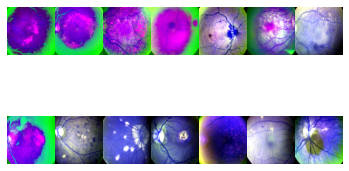

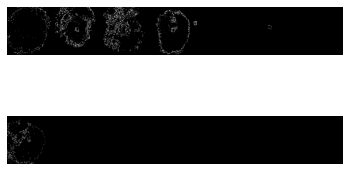

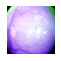

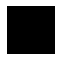

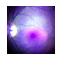

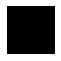

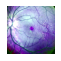

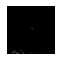

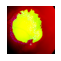

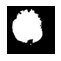

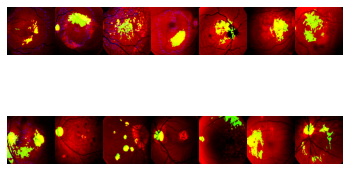

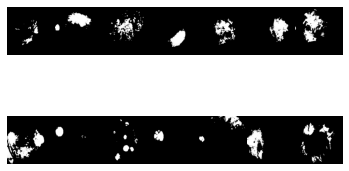

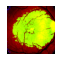

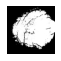

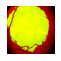

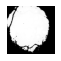

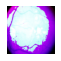

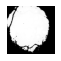

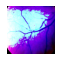

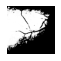

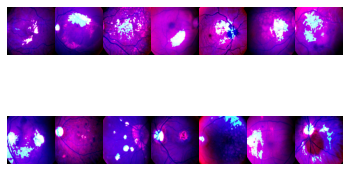

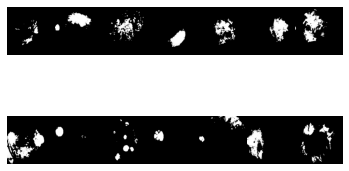

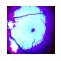

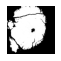

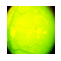

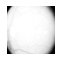

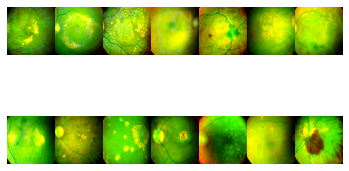

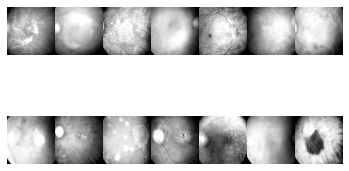

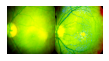

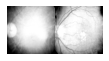

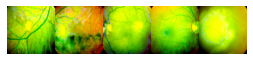

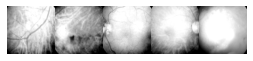

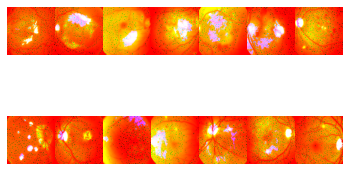

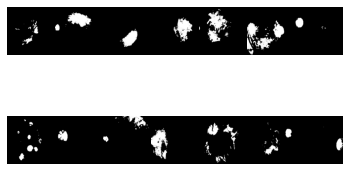

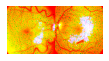

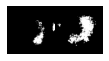

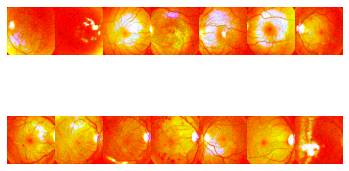

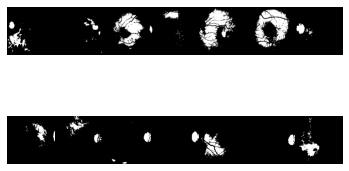

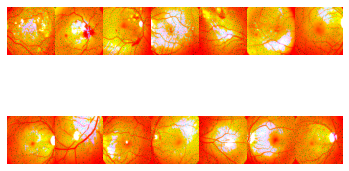

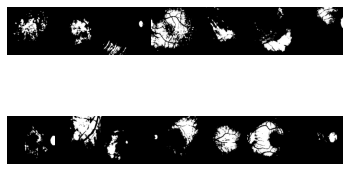

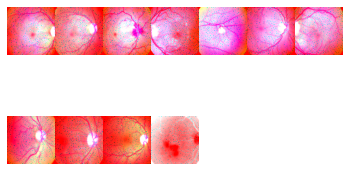

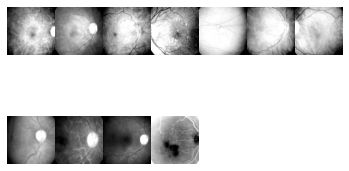

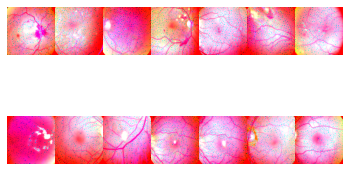

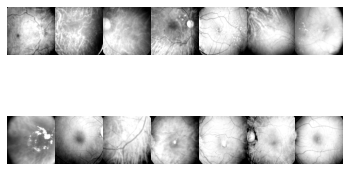

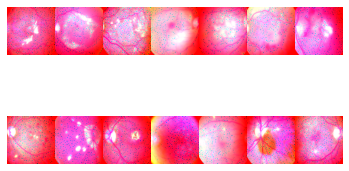

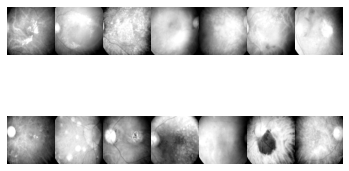

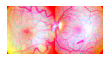

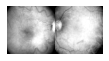

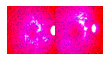

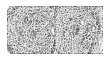

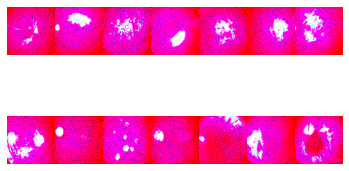

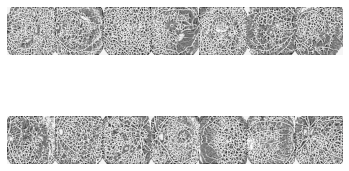

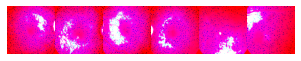

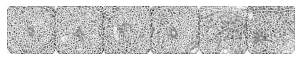

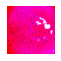

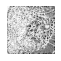

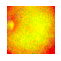

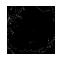

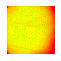

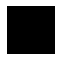

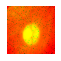

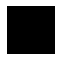

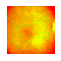

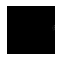

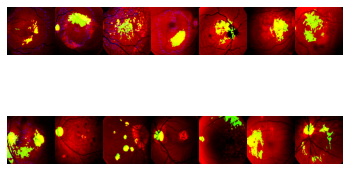

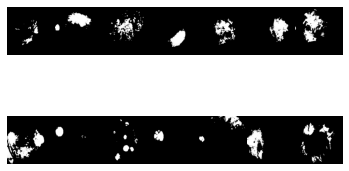

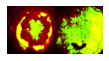

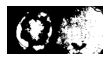

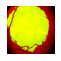

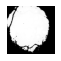

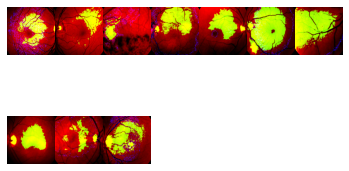

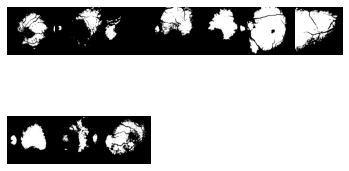

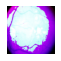

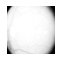

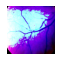

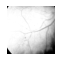

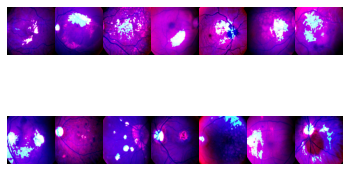

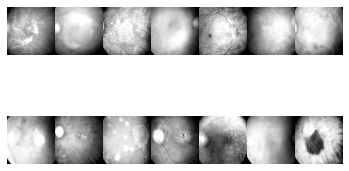

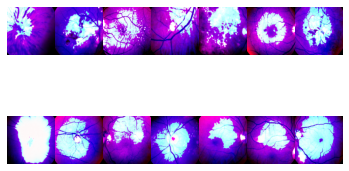

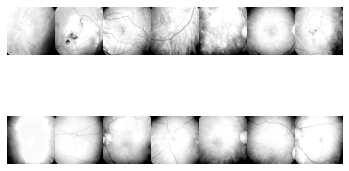

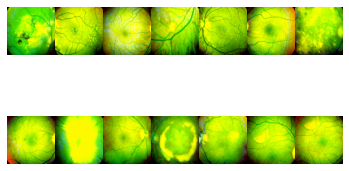

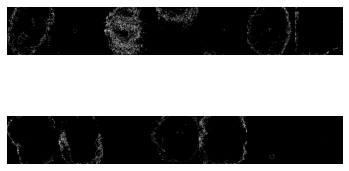

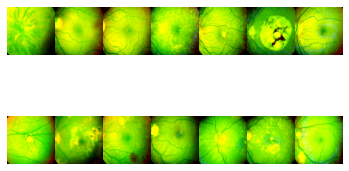

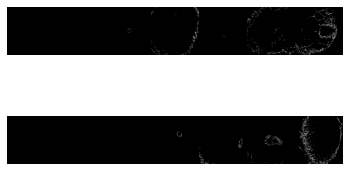

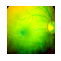

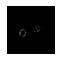

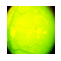

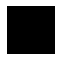

In [57]:
## plotting first 10 images from each cluster
nc = 7
_Nshow = nc*2 
#chanz = [ *list(range(6)), 9, (6,7,8)]  
#_L, _V, _G, _R, _B, _Y, _Ori, _E = 0, 1, 2, 3, 4, 5, (6,7,8), 9
# nz = np.random.randint(0, 397, _Nshow)
# tmp = [ __FMAPZ_n[i]  for i in nz ] 

_VISUALIZOR_CHANZ = {'channelz_origi': [_Ori, _B] ,
                     
                    'channelz_grb': [(_G, _R, _B), _R], 
                     'channelz_gry': [(_G, _R, _Y), _R], 
                     'channelz_gyb': [(_G, _Y, _B), _Y], 
                     
                     'channelz_lbp_gr': [(_L, _G, _R), _R],
                     'channelz_lbp_gy': [(_L, _G, _Y), _Y],
                     'channelz_lbp_ry': [(_L, _R, _Y), _L], 
                     'channelz_lbp_yb': [(_L, _Y, _B), _B], #channelz_lbp_ry, channelz_lbp_yb,
                     
                     'channelz_eigz_rb': [(_E, _R, _B), _R],
                     'channelz_eigz_ry': [(_E, _R, _Y), _Y ],
                     'channelz_eigz_yb': [(_E, _Y, _B), _B]                     
                    }


for cname, results in cluster_results.items():
    _, labelz = results
    for i in range(_n_clusters):        
        tmp = np.array(__FMAPZ_n)[ labelz == i]
        label = f"cluster-{i+1}"         
        for dim in _VISUALIZOR_CHANZ.get(cname, [None,None] ):
            if dim is not None:
                imgz = [fmap[:,:,dim] for fmap in tmp[:_Nshow]]
                utilz.Image.plot_images_list(imgz, nc=nc, save=f"99___{cname}__{label}", tdir=_outdir, cmap='gray')
        



    

In [31]:
# with open(f"{_outdir}/pretrained_encoder.bak.pkl", 'wb') as fd:
#     pickle.dump(encoder_cnn, fd )

# 3. Permute and Run

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.pipeline import Pipeline


import model

In [12]:
dpipez = [
    Pipeline(channelz_origi), # origi only
    
    Pipeline(channelz_g_only), # green only 
    Pipeline(channelz_grb), # green red blue 
    Pipeline(channelz_vgrb),  # vessel, green red blue  
    Pipeline(channelz_vgrby),  # vessel, green red blue  yellow   
    
    Pipeline(channelz_lbp_only), #lbp only 
    Pipeline(channelz_lbp_origi), #lbp and origi 
    Pipeline(channelz_lbp_grn), #lbp green 
    Pipeline(channelz_lbp_grb), #lbp green red blue
    Pipeline(channelz_lbp_grby), #lbp green red blue yellow
    Pipeline(channelz_lbp_vgrb), ## lbp vessel green red blue    
    
    Pipeline(channelz_eigz_only), #eigz_
    Pipeline(channelz_eigz_lbp), #eigz_ lbp 
    Pipeline(channelz_eigz_rb), #eigz_ lbp rb 
    Pipeline(channelz_eigz_rby), #eigz_ lbp rb yellow
    Pipeline(channelz_eigz_lbp_rb), #eigz_ lbp_rb 
#     Pipeline(channelz_eigz_lbp_rby), #eigz_ lbp_rb yellow
]
mpipez = [ ( Pipeline(flattenor+[('svm', svm.SVC() ) ]), {'kernel':('linear', 'rbf'), 'C':[1, 10]}) ,  ## 
            ( Pipeline(flattenor+[('logit', LogisticRegression() ) ]), {'C':[1,10]} ), ##
         ]  


In [39]:
def run_sub_sample(nm='fundusEDA', n=None, dpipez=dpipez, mpipez=mpipez, outdir='./output'):
    log_fname = f"xLAB_acc_v3_{nm}_{'ALL' if n is None else n}" 
    report.ZReporter.start(log_fname, log_screen=False) 
    
#     if n is None:        
#         small_df = pdstats.dframe
#     else:
#         small_df = pdstats.dframe.sample(n, random_state=1)  
        
#     X_data = small_df  
#     y_data = small_df['Normal'].values.astype(np.float32) ##TODO: 'dcodez_short'
#     print("Loaded into PdFrame data of size: ", len(small_df) , " and into y_data of size ", len(y_data) )  
#     __X_data = Pipeline(defaultz_setup_X_data).fit_transform( X_data )

    __X_data = FMAPZ_DATA
    print("Loaded and setup X_data", len(__X_data) )
    
    mgr = model.ZTrainingManager() 
    mgr.build_permutationz(data_pipez=dpipez, model_pipez=mpipez)
    search_output = mgr.run( __X_data , _Y_DATA, train_test_split=1.)
    c="*="
    print(f"{c*10} End ZTrainingManager for sub_n_{n} {c*10}\n {search_output[0]}")
    
    ## get metrics for plotting 
    grp = [f"{s[0]}__{s[1]}" for s in search_output]
#     hue_grp = [f"{s[1].split(" ")[0]}" for s in search_output]
    acc = [s[2] for s in search_output]
    acc = np.nan_to_num (np.array( acc) )
    max_acc = acc.max()
    min_acc = np.min( acc[np.nonzero(acc)] )
    mean_acc = acc.mean()
    median_acc = np.median(acc)
    print(f"Max: {max_acc} \tMin: {min_acc} \tMean: {mean_acc} \tMedia: {median_acc}")
    
    with open(f"{outdir}/{log_fname}.csv", 'w') as fd:
        for g, a in zip(grp, acc):
            fd.write( "\t".join( [str(g), str(a)] ))
            fd.write( "\n")
    
    ## 3. plot for all metrics
    plt.figure(figsize=(15,20))
    plt.barh( grp, acc);
    plt.axvline(x=max_acc, color='r', linestyle='--')
    plt.axvline(x=min_acc, color='gray', linestyle='--')
    plt.title("Permutation Accuracies")
    plt.tight_layout()
    plt.savefig( f"{outdir}/{log_fname}__ALL_METRICS.png", facecolor='w', dpi=100)
    plt.show();
    #plt.clf()
    ## 4. get diffs/uncommon
    grp_diff = []
    acc_diff = []
    base_set = None 
    g_lbl="{}_{}".format
    for sout in search_output:
        g1, g2, ac = sout[0], sout[1], sout[2]        
        if (base_set is None) and (ac == max_acc):
            base_set = (g_lbl(g1, g2), ac )
        if ac < max_acc:
            grp_diff.append( g_lbl(g1, g2) )
            acc_diff.append( ac )
    grp_diff = [base_set[0],] + grp_diff
    acc_diff = [base_set[1],] + acc_diff

    plt.figure(figsize=(15,7))
    plt.barh( grp_diff, acc_diff);
    plt.axvline(x=max_acc, color='r', linestyle='--')
    plt.axvline(x=min_acc, color='gray', linestyle='--')
    plt.grid(b=True, which='minor', axis='x', color='#000000', linestyle='--')
    plt.title("Different from Max")
    plt.tight_layout()
    plt.savefig( f"{outdir}/{log_fname}__DIFF__METRICS.png", facecolor='w', dpi=100)
    plt.show();

  0%|          | 0/32 [00:00<?, ?it/s]

Loaded and setup X_data 397


100%|██████████| 32/32 [17:32<00:00, 32.90s/it]


*=*=*=*=*=*=*=*=*=*= End ZTrainingManager for sub_n_None *=*=*=*=*=*=*=*=*=*=
 ['Perm_1', 'svm channelz_origi', 0.901768945738795, Pipeline(steps=[('data_pipe',
                 Pipeline(steps=[('channelz_origi',
                                  ChannelzSelector(ls_channelz=(6, 7, 8)))])),
                ('model_pipe',
                 Pipeline(steps=[('flatten', Flattenor()),
                                 ('svm', SVC(C=1))]))]), {'model_pipe__svm__C': 1, 'model_pipe__svm__kernel': 'rbf'}]
Max: 0.901768945738795 	Min: 0.8715166742804934 	Mean: 0.8972827362824222 	Media: 0.901768945738795


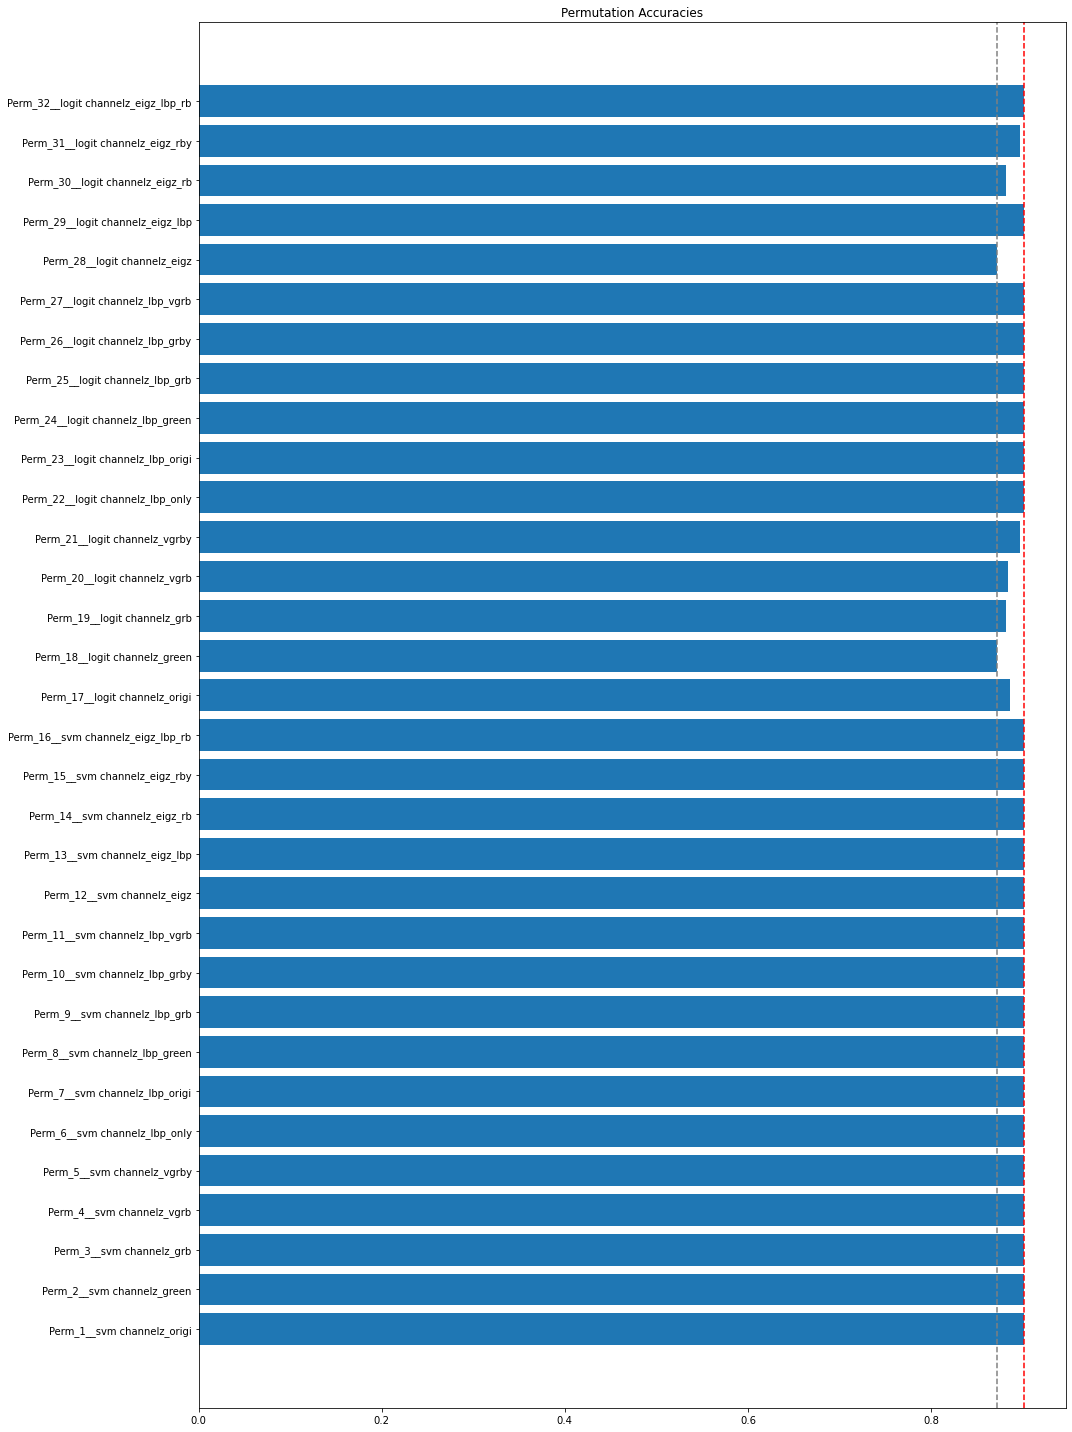

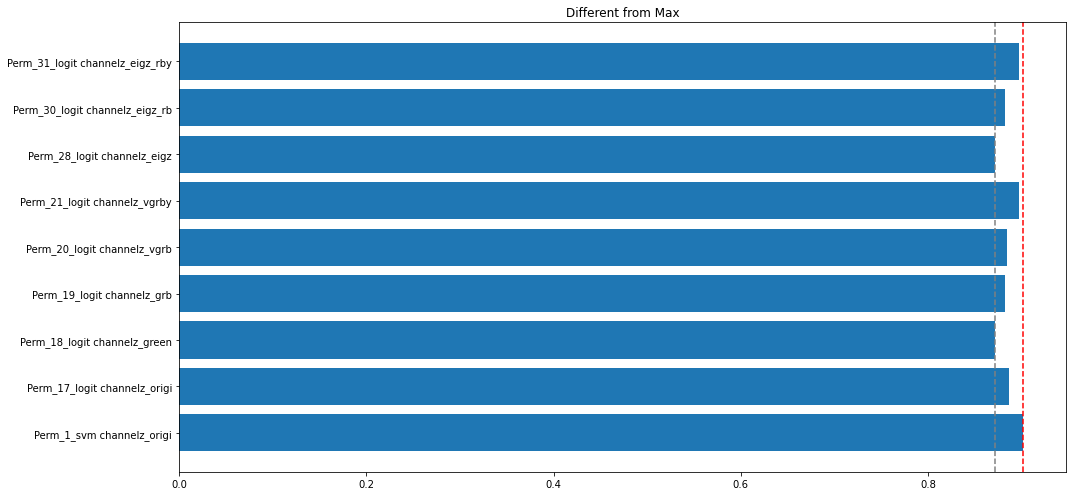

In [40]:
run_sub_sample(nm=f'{_N_CLASSES}-ary')

In [60]:
import seaborn as sns
sns.set_theme(style='ticks', palette='pastel')
sns.color_palette("mako", as_cmap=True)

In [61]:
search_outputs = pd.read_csv("./output/20210319_all_lba_rgb_svm_logit.tsv", sep="\t")
search_outputs.describe(include='all')

,Mode,Permutation,Classifier,Features,Accuracy
count,58,58,58,58,58.000000
unique,2,32,2,16,NaN
top,With_LBA,Perm_19,logit,channelz_origi,NaN
freq,32,2,29,4,NaN
mean,NaN,NaN,NaN,NaN,0.896689
std,NaN,NaN,NaN,NaN,0.010787
min,NaN,NaN,NaN,NaN,0.848853
25%,NaN,NaN,NaN,NaN,0.901769
50%,NaN,NaN,NaN,NaN,0.901769
75%,NaN,NaN,NaN,NaN,0.901769


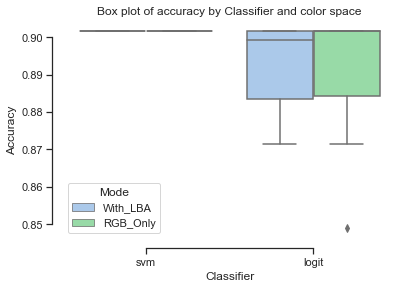

In [63]:
sns.boxplot(x='Classifier', y='Accuracy', hue='Mode', data=search_outputs,
           palette=['b','g'])
sns.despine(offset=10, trim=True)
plt.title("Box plot of accuracy by Classifier and color space");

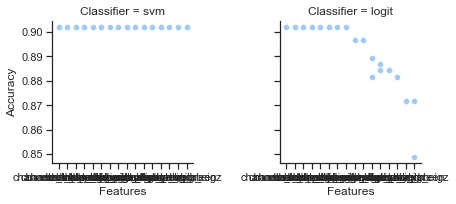

In [76]:
g = sns.FacetGrid( search_outputs, col='Classifier')
g.map( sns.scatterplot, 'Features', 'Accuracy',)
# g.map( sns.regplot, 'Mode', 'Accuracy', color='0.3', fit_reg=False, x_jitter=.1)
g.add_legend(); 

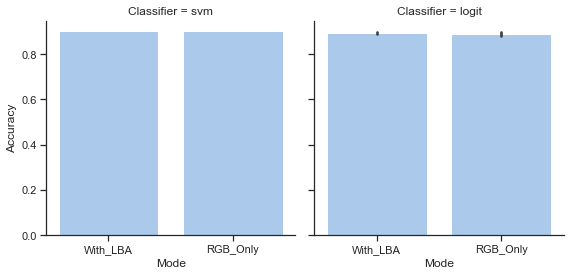

In [82]:
g = sns.FacetGrid( search_outputs, col='Classifier', height=4, aspect=1)
g.map( sns.barplot, 'Mode', 'Accuracy')
g.add_legend(); 

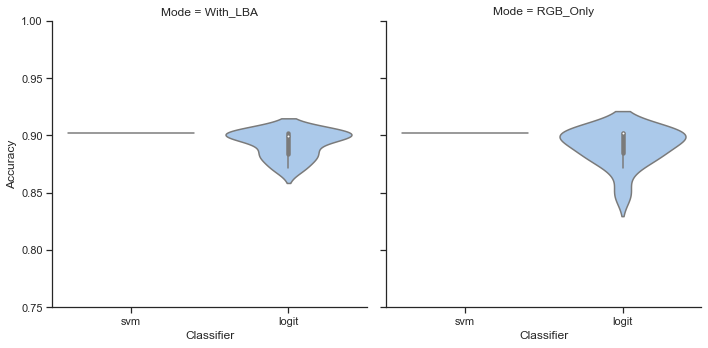

In [103]:
g = sns.FacetGrid(search_outputs, col="Mode", col_wrap=2, height=5, ylim=(0.75, 1))
# g.map(sns.boxplot, "Classifier", "Accuracy");
g.map(sns.violinplot, "Classifier", "Accuracy");
# plt.title("Average accuracy by classifier and color space (n=59)")

plt.show();